In [1]:
from pathlib import Path

import mne
mne.viz.set_browser_backend("matplotlib")
from mne_bids import read_raw_bids, get_bids_path_from_fname

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Using matplotlib as 2D backend.


In [2]:
rawdata_dir = Path("../rawdata")
participants_tsv = pd.read_csv(rawdata_dir / "participants.tsv", sep="\t")

## Demographics

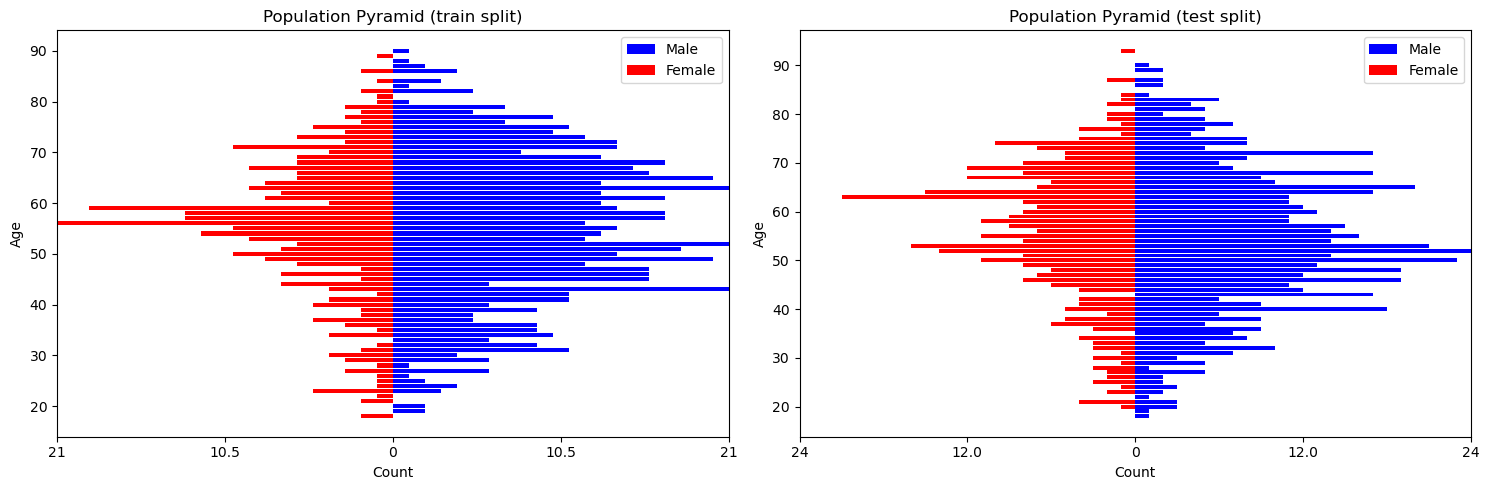

In [4]:
# Plot population pyramid for each split
splits = ['train', 'test']

# Create a figure with 3 subplots, one for each split
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, split in enumerate(splits):
    # Filter data for the current split
    data = participants_tsv[participants_tsv['split'] == split]
    
    # Create a population pyramid plot
    male = data[data['sex'] == 'M']['age'].value_counts().sort_index()
    female = -data[data['sex'] == 'F']['age'].value_counts().sort_index()
    
    axes[i].barh(male.index, male.values, color='blue', label='Male')
    axes[i].barh(female.index, female.values, color='red', label='Female')    
    axes[i].set_title(f'Population Pyramid ({split} split)')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('Age')
    axes[i].legend()
    
    # Make x-axis symmetric and set xticks to be positive in both directions
    max_x = max(male.max(), abs(female.min()))
    axes[i].set_xlim([-max_x, max_x])
    axes[i].set_xticks([-max_x, -max_x/2, 0, max_x/2, max_x])
    axes[i].set_xticklabels([max_x, max_x/2, 0, max_x/2, max_x])

plt.tight_layout()
plt.show()

## Recording Durations

In [6]:
# Extract recording durations (in minutes and floored to the nearest minute)
durations = []
files = list(rawdata_dir.glob("**/*.vhdr"))
for file in files:
    raw = mne.io.read_raw_brainvision(file, verbose=False)
    durations.append(raw.times[-1] // 60.)  # in minutes

durations = pd.Series(durations)

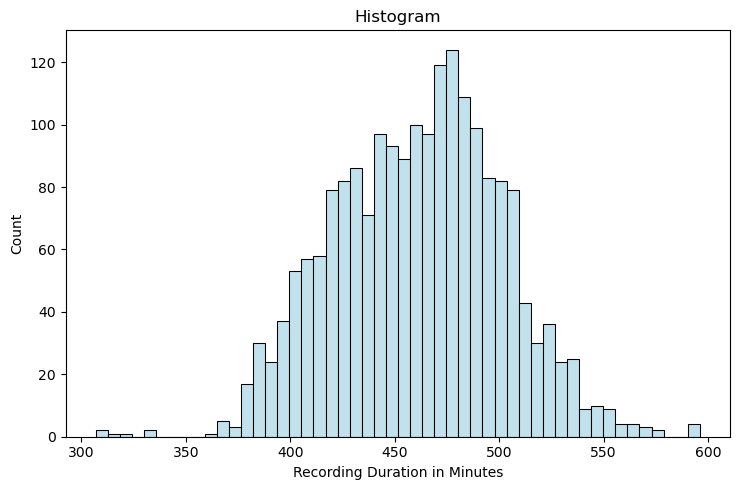

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

sns.histplot(durations, bins=50, color='lightblue', ax=ax)
ax.set_xlabel('Recording Duration in Minutes')
ax.set_title('Histogram')

plt.tight_layout()
plt.show()

In [17]:
durations.describe()

count    1983.000000
mean      461.209783
std        40.265959
min       307.000000
25%       432.000000
50%       464.000000
75%       489.000000
max       596.000000
dtype: float64

The shortest recording is 5h 7min, the majority of recordings are between 7-8 hours, and the longest one is 9h 56min.

## Event annotations

In [ ]:
# Extract event information (type, count, and duration)
annotation_stats = []
files = list(rawdata_dir.glob("**/*.vhdr"))
for file in files:
    raw = read_raw_bids(get_bids_path_from_fname(file), verbose=False)
    annotations = raw.annotations.to_data_frame()
    stats = annotations.groupby("description").agg(total_duration=("duration", "sum"), annotation_count=("duration", "size")).reset_index()
    stats["file"] = file.name
    annotation_stats.append(stats)

annotation_stats = pd.concat(annotation_stats, ignore_index=True)

# Add participant id and split information
annotation_stats["participant_id"] = annotation_stats["file"].str.split("_").str[0]
annotation_stats = annotation_stats.merge(participants_tsv["participant_id"], on="participant_id")

# Compute summary stats across splits
annotation_summary_stats = annotation_stats.groupby(
    ["description"]
).agg(
    total_duration=("total_duration", "sum"),
    total_annotation_count=("annotation_count", "sum"),
    file_count=("file", "size")
).reset_index()

### Overview

In [39]:
annotation_summary_stats

,description,total_duration,total_annotation_count,file_count,total_duration_hours
0,arousal,1.273160e+06,39983,951,353.655432
1,arousal_bruxism,9.000000e+01,30,2,0.025000
2,arousal_noise,3.000000e+00,1,1,0.000833
3,arousal_plm,1.317000e+02,36,10,0.036583
4,arousal_rera,8.656913e+05,43822,951,240.469796
5,arousal_snore,7.540000e+01,28,9,0.020944
6,arousal_spontaneous,2.430950e+02,70,16,0.067526
7,non-arousal,1.696301e+07,113099,994,4711.945957
8,nonrem1,4.110811e+06,43131,993,1141.891944
9,nonrem2,1.133861e+07,38556,993,3149.613886


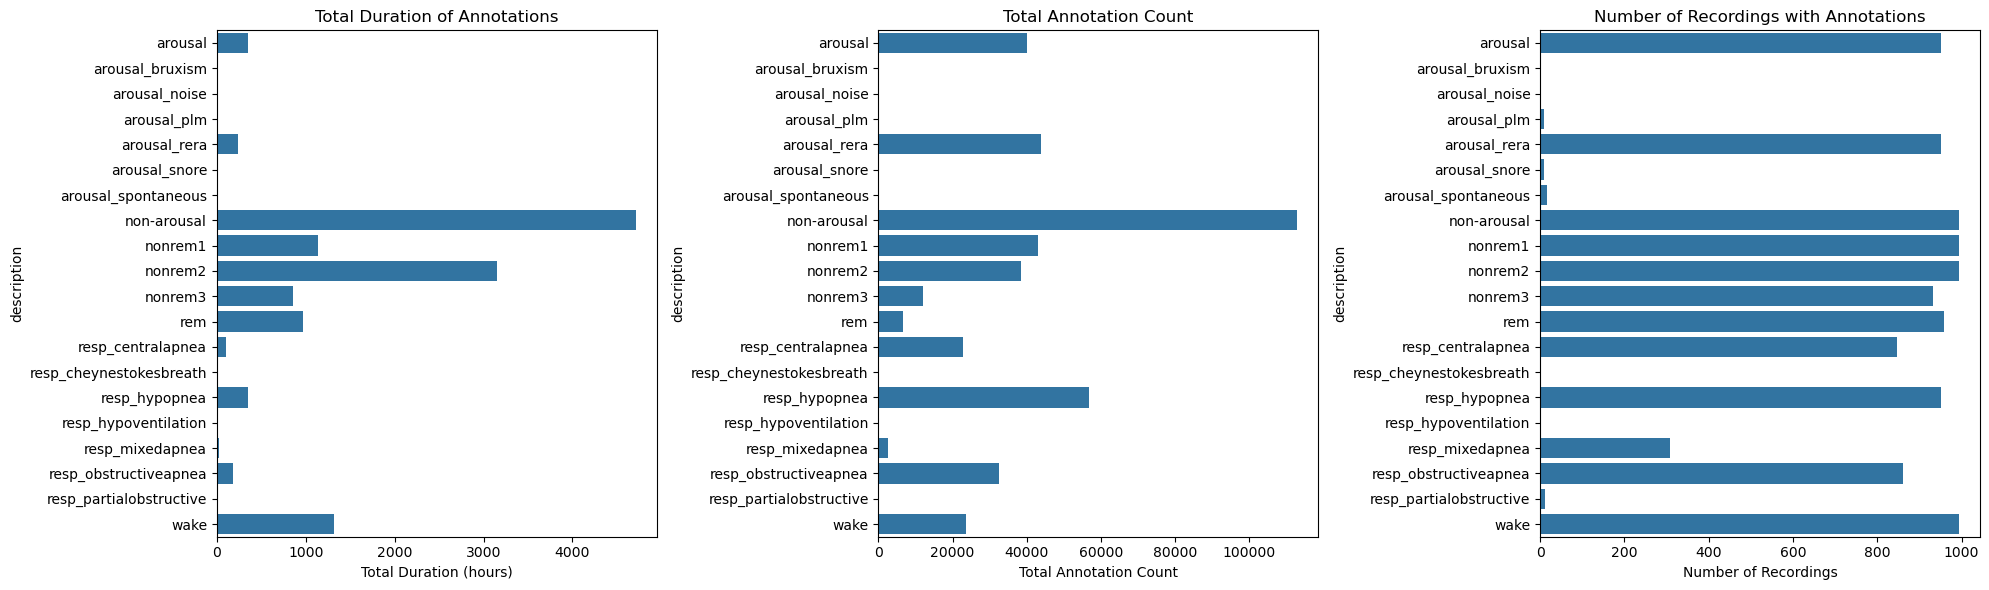

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Convert total_duration from seconds to hours
annotation_summary_stats['total_duration_hours'] = annotation_summary_stats['total_duration'] / 3600

# Horizontal bar plot for Total Duration of Annotations in hours
sns.barplot(y='description', x='total_duration_hours', data=annotation_summary_stats, ax=axes[0], orient='h')
axes[0].set_title('Total Duration of Annotations')
axes[0].set_xlabel("Total Duration (hours)")

# Horizontal bar plot for Total Annotation Count
sns.barplot(y='description', x='total_annotation_count', data=annotation_summary_stats, ax=axes[1], orient='h')
axes[1].set_title('Total Annotation Count')
axes[1].set_xlabel("Total Annotation Count")

# Horizontal bar plot for Number of Recordings with Annotations
sns.barplot(y='description', x='file_count', data=annotation_summary_stats, ax=axes[2], orient='h')
axes[2].set_title('Number of Recordings with Annotations')
axes[2].set_xlabel("Number of Recordings")

plt.tight_layout()
plt.show()

### Sleep stage labels

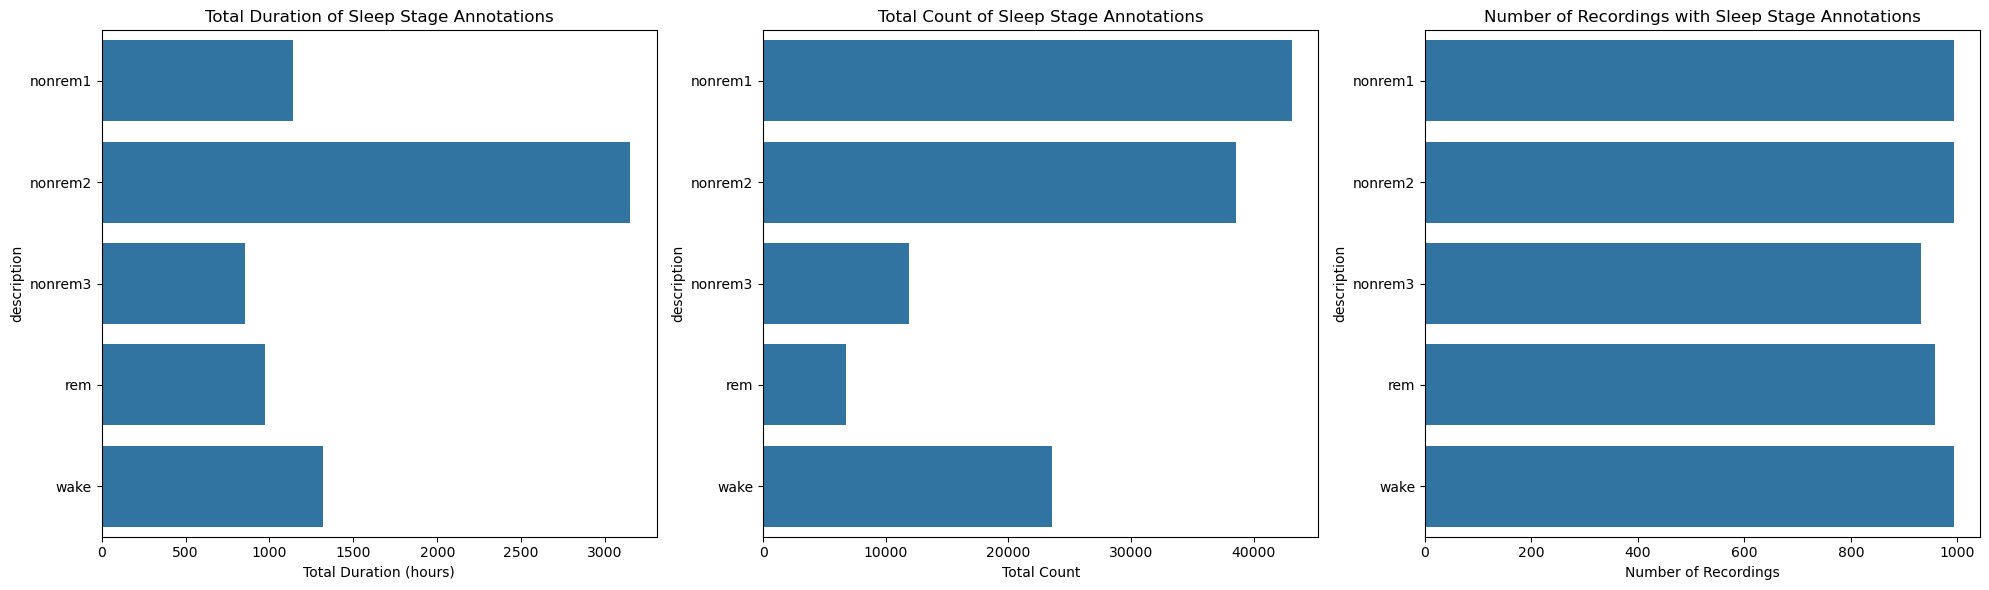

In [40]:
sleep_stage_labels = ["wake", "nonrem1", "nonrem2", "nonrem3", "rem",]
sleep_stage_stats = annotation_summary_stats.copy()[annotation_summary_stats['description'].isin(sleep_stage_labels)]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Convert total_duration from seconds to hours
sleep_stage_stats['total_duration_hours'] = sleep_stage_stats['total_duration'] / 3600

# Horizontal bar plot for Total Duration of Annotations in hours
sns.barplot(y='description', x='total_duration_hours', data=sleep_stage_stats, ax=axes[0], orient='h')
axes[0].set_title('Total Duration of Sleep Stage Annotations')
axes[0].set_xlabel("Total Duration (hours)")

# Horizontal bar plot for Total Annotation Count
sns.barplot(y='description', x='total_annotation_count', data=sleep_stage_stats, ax=axes[1], orient='h')
axes[1].set_title('Total Count of Sleep Stage Annotations')
axes[1].set_xlabel("Total Count")

# Horizontal bar plot for Number of Recordings with Annotations
sns.barplot(y='description', x='file_count', data=sleep_stage_stats, ax=axes[2], orient='h')
axes[2].set_title('Number of Recordings with Sleep Stage Annotations')
axes[2].set_xlabel("Number of Recordings")

plt.tight_layout()
plt.show()

Sleep stage labels are approximately balanced on the recording (=participant) level, where we have more than 900 recordings for each sleep stage.
In terms of the duration and count of annotated segments, nonrem2 annotations are much longer and the counts for annotations of the different
stages vary a lot. There are more than 7 times as many nonrem1 annotations than rem annotations.

### Binary arousal labels

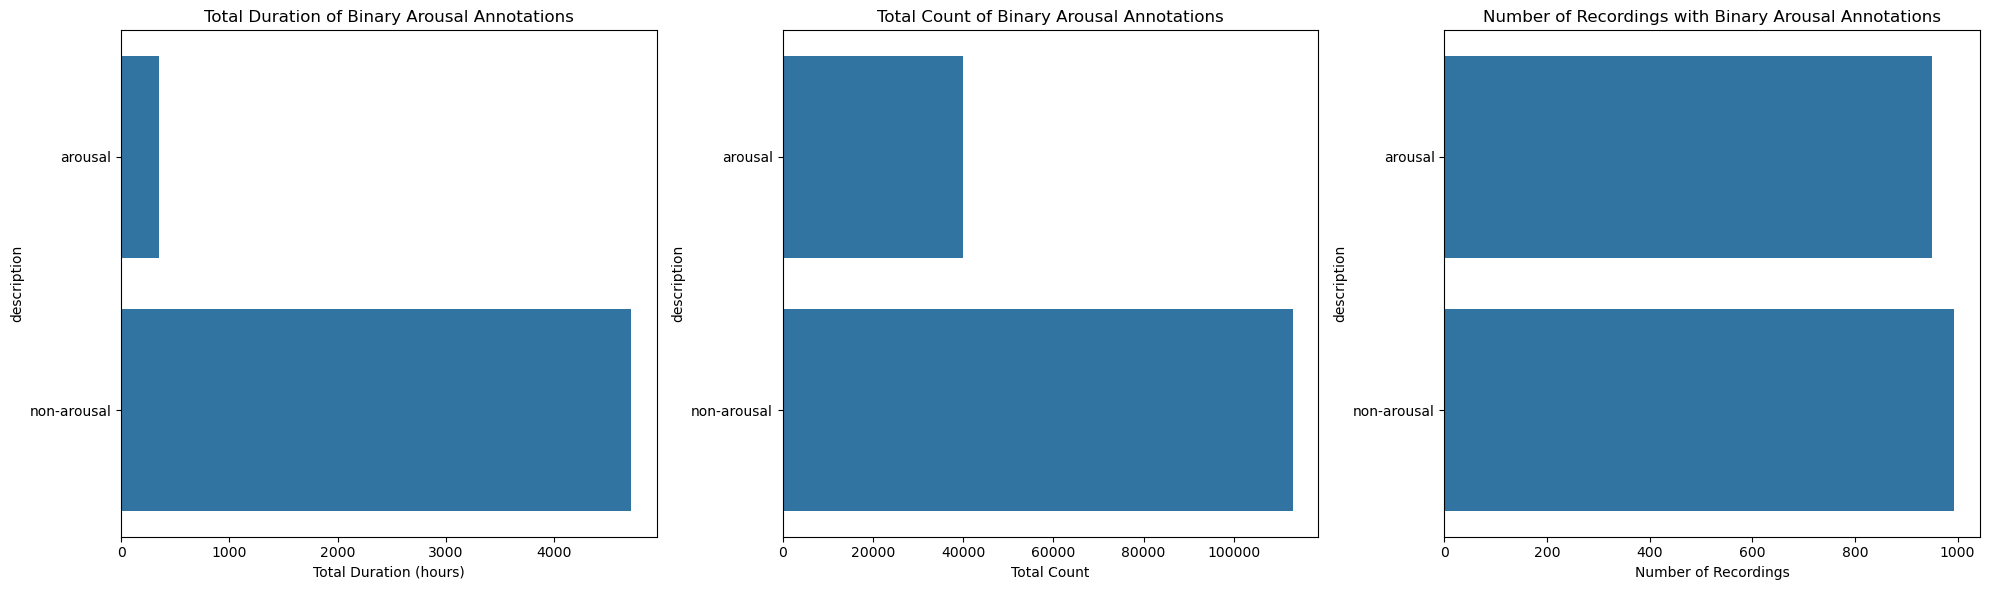

In [41]:
binary_arousal_labels = ["arousal", "non-arousal",]
binary_arousal_stats = annotation_summary_stats.copy()[annotation_summary_stats['description'].isin(binary_arousal_labels)]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Convert total_duration from seconds to hours
binary_arousal_stats['total_duration_hours'] = binary_arousal_stats['total_duration'] / 3600

# Horizontal bar plot for Total Duration of Annotations in hours
sns.barplot(y='description', x='total_duration_hours', data=binary_arousal_stats, ax=axes[0], orient='h')
axes[0].set_title('Total Duration of Binary Arousal Annotations')
axes[0].set_xlabel("Total Duration (hours)")

# Horizontal bar plot for Total Annotation Count
sns.barplot(y='description', x='total_annotation_count', data=binary_arousal_stats, ax=axes[1], orient='h')
axes[1].set_title('Total Count of Binary Arousal Annotations')
axes[1].set_xlabel("Total Count")

# Horizontal bar plot for Number of Recordings with Annotations
sns.barplot(y='description', x='file_count', data=binary_arousal_stats, ax=axes[2], orient='h')
axes[2].set_title('Number of Recordings with Binary Arousal Annotations')
axes[2].set_xlabel("Number of Recordings")

plt.tight_layout()
plt.show()

Binary arousal annotations are also balanced on the participant level, but there are many more and longer non-arousal annotations than arousal annotations.

### Detailed arousal labels

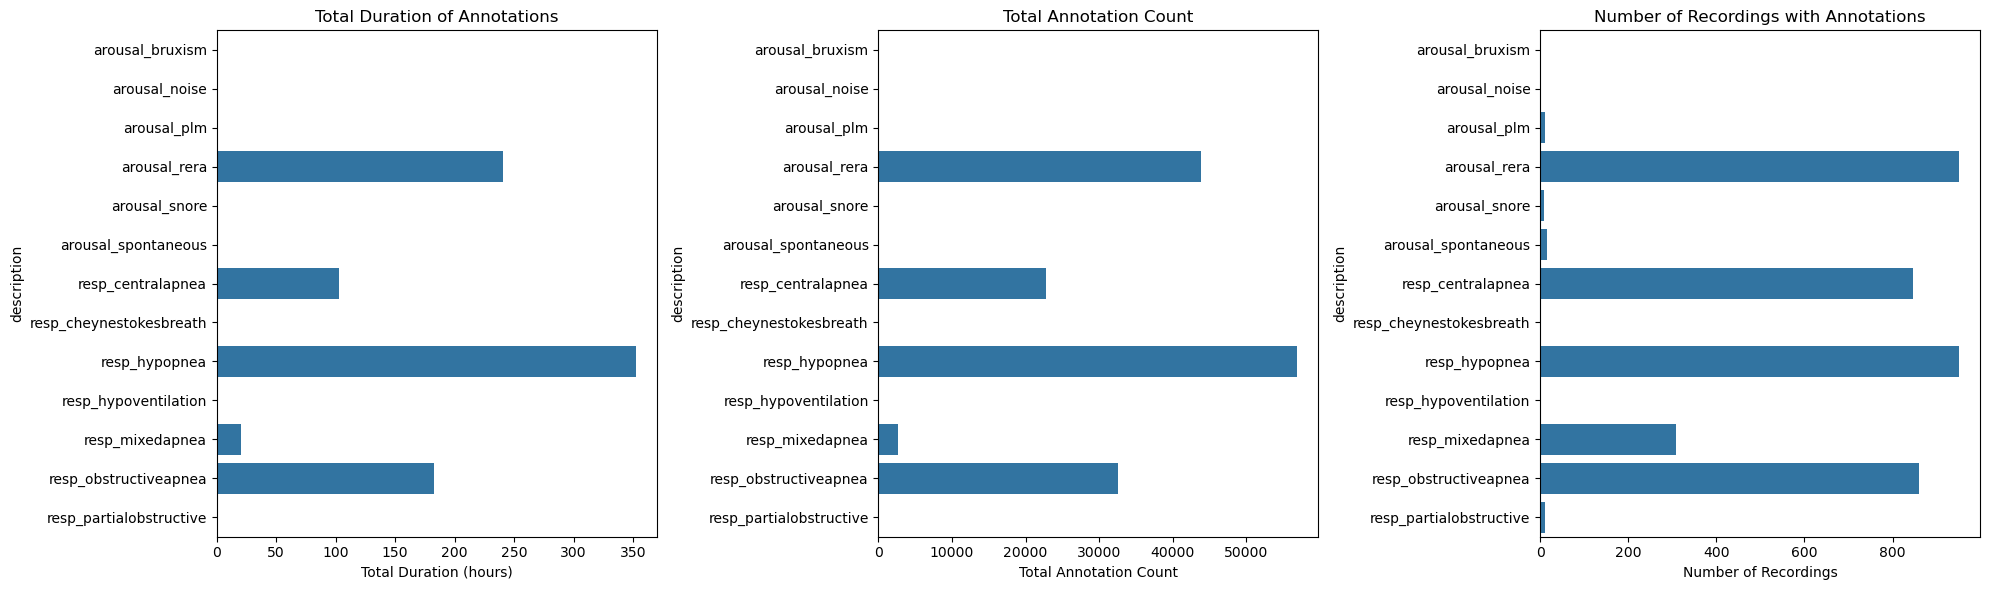

In [38]:
detailed_arousal_labels = [
    "arousal_bruxism", "arousal_noise", "arousal_plm", "arousal_rera", "arousal_snore",
    "arousal_spontaneous", "resp_centralapnea", "resp_cheynestokesbreath", "resp_hypopnea",
    "resp_hypoventilation", "resp_mixedapnea", "resp_obstructiveapnea", "resp_partialobstructive",
]

detailed_arousal_stats = annotation_summary_stats.copy()[annotation_summary_stats['description'].isin(detailed_arousal_labels)]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Convert total_duration from seconds to hours
detailed_arousal_stats['total_duration_hours'] = detailed_arousal_stats['total_duration'] / 3600

# Horizontal bar plot for Total Duration of Annotations in hours
sns.barplot(y='description', x='total_duration_hours', data=detailed_arousal_stats, ax=axes[0], orient='h')
axes[0].set_title('Total Duration of Annotations')
axes[0].set_xlabel("Total Duration (hours)")

# Horizontal bar plot for Total Annotation Count
sns.barplot(y='description', x='total_annotation_count', data=detailed_arousal_stats, ax=axes[1], orient='h')
axes[1].set_title('Total Annotation Count')
axes[1].set_xlabel("Total Annotation Count")

# Horizontal bar plot for Number of Recordings with Annotations
sns.barplot(y='description', x='file_count', data=detailed_arousal_stats, ax=axes[2], orient='h')
axes[2].set_title('Number of Recordings with Annotations')
axes[2].set_xlabel("Number of Recordings")

plt.tight_layout()
plt.show()

In [46]:
detailed_arousal_stats.sort_values(by='total_duration', ascending=True)

,description,total_duration,total_annotation_count,file_count,total_duration_hours
2,arousal_noise,3.000,1,1,0.000833
13,resp_cheynestokesbreath,67.100,3,3,0.018639
5,arousal_snore,75.400,28,9,0.020944
1,arousal_bruxism,90.000,30,2,0.025000
3,arousal_plm,131.700,36,10,0.036583
18,resp_partialobstructive,216.300,11,11,0.060083
6,arousal_spontaneous,243.095,70,16,0.067526
15,resp_hypoventilation,418.700,4,2,0.116306
16,resp_mixedapnea,74606.890,2641,308,20.724136
12,resp_centralapnea,371203.985,22763,847,103.112218


For the detailed arousal annotations, we have large numbers of annotations for the classes
"resp_hypopnea", "arousal_rera", "resp_obstructiveapnea", "resp_centralapnea", and "resp_mexedapnea".
Labels for the other classes are very sparse with only between 1-70 annotations and less than 10 minutes of total duration.